# 0. Применение метода KNN для решения задачи классификации

Набор данных получен в результате переписи населения 1994 года и содержит информацию о некотором количестве людей, проживающих в США. Задача состоит в том, чтобы предсказать, зарабатывает человек более $50к в год или нет. Список признаков:

*   <b>age</b>: возраст человека.
*   <b>workclass</b>: статус занятости.
*   <b>fnlwgt</b>: количество людей, которое, по мнению переписи, представляет запись.
*   <b>education</b>: высший уровень образования, достигнутый человеком.
*   <b>education-num</b>: высший уровень образования, достигнутый человеком в числовой форме.
*   <b>marital-status</b>: семейное положение человека.
*   <b>occupation</b>: общий род занятий человека.
*   <b>relationship</b>: представляет то, чем этот человек является по отношению к другим (перекликается с признаком <b>marital-status</b>).
*   <b>race</b>: раса.
*   <b>sex</b>: пол.
*   <b>capital-gain</b>: прирост капитала.
*   <b>capital-loss</b>: убыток капитала.
*   <b>hours-per-week</b>: число рабочих часов в неделю.
*   <b>native-country</b>: страна происхождения.
*   <b>the label</b>: отклик -- зарабатывает больше $50к или меньше.



## Немного про метрики качества модели

Для начала рассмотрим так называемую матрицу ошибок (confusion matrix)
-- способ разделить объекты на $4$ группы в зависимости от комбинации
истинного класса и ответа классификатора:

-   TP (True Positives) -- верно классифицированные объекты, исходно     относящиеся к классу "$+1$";

-   TN (True Negatives) -- верно классифицированные объекты, исходно     относящиеся к классу "$-1$";

-   FN (False Negatives) -- неверно классифицированные объекты, исходно     относящиеся к классу "$+1$" (ошибка I рода);

-   FP (False Positives) -- неверно классифицированные объекты, исходно     относящиеся к классу "$-1$" (ошибка II рода).

Обычно, конечно, оперируют не абсолютными показателями, а относительными
-- долями (rates), находящимися в диапазоне от $0$ до $1$:

-   доля правильных ответов классификатора (иногда -- точность): $$\mathsf{Accuracy} = \frac{TP + TN}{TP + FP + FN + TN}.$$ Эта величина показывает отношение количества верно классифицированных объектов к общему количеству классифицируемых объектов и, грубо говоря, оценивает вероятность случайному объекту быть правильно классифицированным.

-   доля истинно положительных примеров -- True Positives Rate (TPR) или     Sensitivity (чувствительность) или Recall: $$\mathsf{T P R}=\frac{T P}{T P+F N}.$$ Эта величина показывает отношение количества верно классифицированных объектов, относящихся к классу "$+1$", к общему количеству объектов класса "$+1$". Иными словами -- это оценка вероятности, что объект, относящийся к классу "$+1$" будет классифицирован корректно.

-   доля ложно положительных примеров обозначается как -- False Positives Rate (FPR): $$\mathsf{F P R}=\frac{F P}{FP + TN}.$$ Величина показывает отношение количества неверно классифицированных объектов, относящихся к классу "$-1$", к общему количеству объектов класса "$-1$", или оценивает вероятность, что объект, относящийся к классу "$-1$", будет классифицирован неверно.

-   Специфичность (Specificity) или True Negatives Rate (TNR): $$\mathsf{TNR} = 1 - \mathsf{F P R} =\frac{T N}{T N+F P}.$$ Величина показывает отношение количества верно классифицированных объектов, относящихся к классу "$-1$", к общему количеству объектов класса "$-1$", или оценивает вероятность, что объект, относящийся к классу "$-1$", будет классифицирован верно.

-   Precision (точность): $$\mathsf{Precision} =\frac{TP}{TP + FP}.$$ Величина показывает, какая доля объектов, отнесенных классификатором к классу "$+1$", действительно относится к этому классу.

Естественно возникает вопрос, нет ли какого-то обобщающего критерия,
который может характеризовать качество построенной модели. Один из них --
так называемая $F$-мера ($F_1$-мера, $F$ score, $F_1$ score)
определяется следующим соотношением:
$$F = F_1 = 2 \cdot \frac{\mathsf{Precision} \cdot \mathsf{Recall}}{\mathsf{Precision} + \mathsf{Recall}}.$$

**Замечание**. *$F$-мера является средним гармоническим величин
$\mathsf{Precision}$ и $\mathsf{Recall}$ и заключена в диапазоне
$[0, 1]$. Среднее гармоническое обладает важным свойством: оно близко к
нулю, если хотя бы один из аргументов близок к нулю. Поэтому оно является
куда более предпочтительным, чем, скажем, среднее арифметическое: если
алгоритм относит все объекты к положительному классу, то
$\mathsf{Recall}= 1$, а $\mathsf{Precision}$, скорее всего, будет
небольшим. Но тогда среднее арифметическое будет больше, чем $0.5$, что,
конечно, никуда не годится.*

## Импорт библиотек и чтение набора данных

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer 
import seaborn as sns
from matplotlib import pyplot as plt

Считайте набор данных в датафрейм. Исходя из описания признаков можно сразу избавиться от признаков <code>education</code> и <code>marital-status</code>. Удалите соответствующие колонки из набора данных.

In [3]:
df_train = pd.read_csv('../ML/datasets/adult_data_train.csv')

In [33]:
df_train

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,32,Private,37210,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
1,43,Private,101950,Masters,14,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
2,20,?,122244,HS-grad,9,Never-married,?,Not-in-family,White,Female,0,0,28,United-States,0
3,40,Local-gov,24763,Some-college,10,Divorced,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
4,24,Private,113936,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,35,Self-emp-not-inc,179171,HS-grad,9,Never-married,Sales,Unmarried,Black,Female,0,0,38,Germany,0
26044,39,Private,421633,Some-college,10,Divorced,Protective-serv,Unmarried,Black,Female,0,0,30,United-States,0
26045,55,Private,82098,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,Male,0,0,55,United-States,0
26046,26,Private,50053,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,55,United-States,0


Определите количество числовых и нечисловых признаков.

In [34]:
numerical_cols = [cname for cname in df.columns if df[cname].dtype != 'object']

In [35]:
obj_cols = [cname for cname in df.columns if df[cname].dtype == 'object']

In [36]:
len(obj_cols)

8

In [37]:
obj_cols

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

In [38]:
len(df.columns) == (len(numerical_cols)+len(obj_cols))

True

Постройте гистограмму распределения объектов по классам. Вычислите долю объектов класса $0$.

<Axes: xlabel='label', ylabel='Count'>

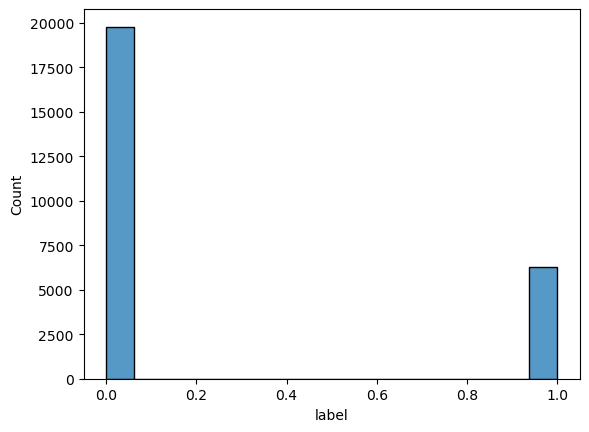

In [39]:
sns.histplot(df, x='label')

In [40]:
len(df[df['label'] == 0])/len(df)

0.7591753685503686

# 1. Построение базовой модели

В качестве первого приближения имеет смысл построить модель классификации, опираясь исключительно на числовые признаки.

Отберите из набора данных только числовые признаки. При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки <b>с параметрами, указанными в вашем задании</b>. Используйте стратификацию по колонке <code>label</code>.

Вычислите выборочное среднее колонки <code>fnlwgt</code> тренировочного набора данных.

Обучите модель <code>KNeighborsClassifier()</code> с параметрами по умолчанию на тренировочных данных. 

Как видно из предыдущего пункта, в наборе данных наблюдается явный дисбаланс представителей классов. Это следует учесть при оценке модели. Вычислите <code>f1_score</code> модели на тестовых данных (рекомендуем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">соответствующую функцию</a> с параметрами по умолчанию.

В качестве альтернативы можно использовать так называемый <a href = "https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html"><code>classification_report()</code></a>, где приведены сразу несколько метрик (не стоит забывать про параметр <code>digits</code>).

In [46]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=obj_cols+['label']), df['label'], 
                                                    test_size = 0.2, random_state=41,
                                                    stratify=df['label'])

In [47]:
X_train['fnlwgt'].mean()

190199.1213648143

In [48]:
X_train

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
4236,33,267859,9,0,0,40
14636,28,230704,9,0,0,40
11353,68,140282,4,0,0,8
11715,26,262617,9,0,0,48
10105,53,260106,15,0,0,50
...,...,...,...,...,...,...
16105,18,200525,7,0,0,25
7227,64,149775,14,0,0,8
21529,42,85995,9,0,0,50
3475,21,243842,9,0,0,40


In [49]:
knn_first = KNeighborsClassifier().fit(X_train, y_train)

In [50]:
preds = knn_first.predict(X_test)
f1_score(y_test, preds)

0.3786557208825039

Стоит помнить, что KNN является метрическим классификатором, поэтому значения признаков перед обучением модели следует нормировать.

Обучите преобразование <code>MinMaxScaler()</code> на тренировочном наборе данных и примените его для тренировочных и тестовых данных.

Вычислите выборочное среднее колонки <code>fnlwgt</code> тренировочного набора данных после нормировки.

Заново обучите и оцените модель на преобразованных данных. Вычислите <code>f1_score()</code> модели.

In [51]:
df = df.drop(columns=['education', 'marital-status'])

In [52]:
obj_cols.remove('education')
obj_cols.remove('marital-status')
obj_cols

['workclass', 'occupation', 'relationship', 'race', 'sex', 'native-country']

In [53]:
scaler = MinMaxScaler().fit(X_train)

In [54]:
X_train_scaled = pd.DataFrame(scaler.transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))
X_train_scaled.columns = X_train.columns
X_test_scaled.columns = X_test.columns

In [55]:
X_train_scaled

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,0.219178,0.173574,0.533333,0.0,0.0,0.397959
1,0.150685,0.148340,0.533333,0.0,0.0,0.397959
2,0.698630,0.086930,0.200000,0.0,0.0,0.071429
3,0.123288,0.170014,0.533333,0.0,0.0,0.479592
4,0.493151,0.168309,0.933333,0.0,0.0,0.500000
...,...,...,...,...,...,...
20833,0.013699,0.127844,0.400000,0.0,0.0,0.244898
20834,0.643836,0.093377,0.866667,0.0,0.0,0.071429
20835,0.342466,0.050060,0.533333,0.0,0.0,0.500000
20836,0.054795,0.157263,0.533333,0.0,0.0,0.397959


In [56]:
X_train_scaled['fnlwgt'].describe()

count    20838.000000
mean         0.120831
std          0.071595
min          0.000000
25%          0.072093
50%          0.113151
75%          0.152951
max          1.000000
Name: fnlwgt, dtype: float64

In [57]:
knn_second = KNeighborsClassifier().fit(X_train_scaled, y_train)

In [58]:
preds = knn_second.predict(X_test_scaled)
f1_score(y_test, preds)

0.504655493482309

Видно, что после линейной нормировки качество выросло. 

<b>Важно: </b>На дальнейших этапах подразумевается использование линейной нормировки непосредственно перед обучением без дополнительных напоминаний.

# 2. Работа с нечисловыми признаками

## Визуализация

Для дальнейшего улучшения качества модели имеет смысл задействовать нечисловые признаки исходного датасета (без колонок <code>education</code> и <code>marital-status</code>). 

Постройте гистограммы, иллюстрирующие частоту того или иного значения по каждому нечисловому признаку, например, при помощи <code>sns.barplot()</code>.

In [59]:
df[obj_cols]

,workclass,occupation,relationship,race,sex,native-country
0,Private,Exec-managerial,Husband,White,Male,United-States
1,Private,Exec-managerial,Not-in-family,White,Female,United-States
2,?,?,Not-in-family,White,Female,United-States
3,Local-gov,Transport-moving,Unmarried,White,Male,United-States
4,Private,Prof-specialty,Own-child,White,Male,United-States
...,...,...,...,...,...,...
26043,Self-emp-not-inc,Sales,Unmarried,Black,Female,Germany
26044,Private,Protective-serv,Unmarried,Black,Female,United-States
26045,Private,Exec-managerial,Husband,Asian-Pac-Islander,Male,United-States
26046,Private,Exec-managerial,Husband,White,Male,United-States


sex


<Axes: >

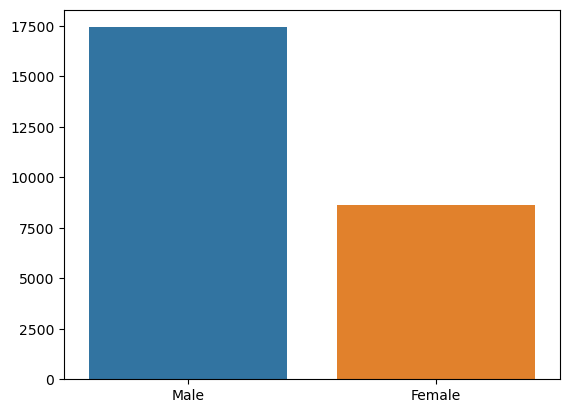

In [60]:
print(obj_cols[4])
bar_dict = df[obj_cols[4]].value_counts().to_dict()

keys = list(bar_dict.keys())
vals = [float(bar_dict[k]) for k in keys]
sns.barplot(x=keys, y= vals)

## Удаление пропущенных значений

Определите число строк исходного набора данных (без колонок <code>education</code> и <code>marital-status</code>), в которых присутствует хотя бы одно пропущенное значение.

In [61]:
obj_cols

['workclass', 'occupation', 'relationship', 'race', 'sex', 'native-country']

In [62]:
for obj in obj_cols:
    df[obj] = df[obj].apply(lambda x: None if x == '?' else x)

In [63]:
df.isna().sum()

age                  0
workclass         1473
fnlwgt               0
education-num        0
occupation        1479
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     458
label                0
dtype: int64

In [64]:
df[(df['workclass'].isna() == True) | (df['occupation'].isna() == True) | (df['native-country'].isna() == True)]

,age,workclass,fnlwgt,education-num,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
2,20,None,122244,9,None,Not-in-family,White,Female,0,0,28,United-States,0
9,28,None,149646,10,None,Own-child,White,Female,0,0,20,None,0
14,60,None,251572,9,None,Not-in-family,White,Male,0,0,35,Poland,0
15,34,None,317219,10,None,Wife,White,Female,0,0,20,United-States,1
40,36,None,94954,11,None,Not-in-family,White,Female,0,0,20,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25972,18,None,165532,8,None,Own-child,White,Male,0,0,25,United-States,0
26007,19,Private,258633,10,Adm-clerical,Own-child,White,Female,0,0,25,None,0
26011,45,None,260953,14,None,Husband,White,Male,0,0,40,United-States,0
26021,66,None,129476,13,None,Husband,White,Male,0,0,6,United-States,0


In [65]:
1914/len(df)

0.07347972972972973

Видно, что в датасете содержится менее 10% строк, содержащих пропуски. Выкидывать такое количество строк — не очень хорошее дело, но почему бы не попробовать обойтись без них. 

Удалите строки, содеражащие пропуски. Произведите <code>one-hot</code> кодировние нечисловых признаков, например, с помощью <code>pd.get_dummies(drop_first=True)</code>.

Введите число полученных признаков.

In [66]:
df_dropped = df.dropna()

In [67]:
df_dropped

,age,workclass,fnlwgt,education-num,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,32,Private,37210,13,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
1,43,Private,101950,14,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
3,40,Local-gov,24763,10,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
4,24,Private,113936,13,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0
5,51,Private,237630,9,Tech-support,Husband,White,Male,7298,0,50,United-States,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,35,Self-emp-not-inc,179171,9,Sales,Unmarried,Black,Female,0,0,38,Germany,0
26044,39,Private,421633,10,Protective-serv,Unmarried,Black,Female,0,0,30,United-States,0
26045,55,Private,82098,9,Exec-managerial,Husband,Asian-Pac-Islander,Male,0,0,55,United-States,0
26046,26,Private,50053,13,Exec-managerial,Husband,White,Male,0,0,55,United-States,0


In [33]:
len(df)

26048

In [68]:
df_dropped.isna().sum()

age               0
workclass         0
fnlwgt            0
education-num     0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
label             0
dtype: int64

In [69]:
df_dropped = pd.get_dummies(df_dropped, drop_first=True)

In [70]:
bool_data = [cname for cname in df_dropped if df_dropped[cname].dtype == 'bool']

In [71]:
for bool_d in bool_data:
    df_dropped[bool_d] = df_dropped[bool_d].astype('int64')

In [72]:
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24134 entries, 0 to 26047
Data columns (total 76 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   age                                        24134 non-null  int64
 1   fnlwgt                                     24134 non-null  int64
 2   education-num                              24134 non-null  int64
 3   capital-gain                               24134 non-null  int64
 4   capital-loss                               24134 non-null  int64
 5   hours-per-week                             24134 non-null  int64
 6   label                                      24134 non-null  int64
 7   workclass_Local-gov                        24134 non-null  uint8
 8   workclass_Private                          24134 non-null  uint8
 9   workclass_Self-emp-inc                     24134 non-null  uint8
 10  workclass_Self-emp-not-inc                 241

In [73]:
len(df_dropped.columns)

76

In [75]:
X_train, X_test, y_train, y_test = train_test_split(df_dropped.drop(columns='label'), df_dropped['label'], 
                                                    test_size = 0.2, random_state=41,
                                                    stratify=df_dropped['label'])

In [76]:
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))
X_train_scaled.columns = X_train.columns
X_test_scaled.columns = X_test.columns

Обучите модель классификации аналогично тому, как это было проделано для базовой модели. Вычислите <code>f1_score()</code> модели.



In [77]:
knn_third = KNeighborsClassifier().fit(X_train_scaled.values, y_train)

In [78]:
preds = knn_third.predict(X_test_scaled.values)
f1_score(y_test, preds)

0.6001838235294118

Точность модели увеличилась по сравнению с моделью, которая использовала только числовые признаки.

## Заполнение пропущенных значений

Возможно точность еще повысится, если задействовать строки с пропущенными значениями. Используя исходный датасет (без колонок <code>education</code> и <code>marital-status</code>), заполните пропуски самым часто встречающимся значением в рамках столбца.

In [79]:
df

,age,workclass,fnlwgt,education-num,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,32,Private,37210,13,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
1,43,Private,101950,14,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
2,20,None,122244,9,None,Not-in-family,White,Female,0,0,28,United-States,0
3,40,Local-gov,24763,10,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
4,24,Private,113936,13,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,35,Self-emp-not-inc,179171,9,Sales,Unmarried,Black,Female,0,0,38,Germany,0
26044,39,Private,421633,10,Protective-serv,Unmarried,Black,Female,0,0,30,United-States,0
26045,55,Private,82098,9,Exec-managerial,Husband,Asian-Pac-Islander,Male,0,0,55,United-States,0
26046,26,Private,50053,13,Exec-managerial,Husband,White,Male,0,0,55,United-States,0


Далее по уже знакомому сценарию: <code>one-hot</code>, <code>split</code>, <code>scaling</code>, обучение и оценка.

Вычислите <code>f1_score()</code> модели.

In [80]:
imputer = SimpleImputer(missing_values=None, strategy='most_frequent').fit(df)

In [81]:
df_imputed = pd.DataFrame(imputer.transform(df))
df_imputed.columns = df.columns

In [82]:
for num_col in numerical_cols:
    df_imputed[num_col] = df_imputed[num_col].astype('int64')

In [83]:
df_imputed = pd.get_dummies(df_imputed, drop_first=True)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(df_imputed.drop(columns='label'), df_imputed['label'], 
                                                    test_size = 0.2, random_state=41,
                                                    stratify=df_imputed['label'])

In [86]:
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))
X_train_scaled.columns = X_train.columns
X_test_scaled.columns = X_test.columns

In [87]:
len(X_test_scaled.columns), len(X_train.columns)

(76, 76)

In [88]:
knn_fourth = KNeighborsClassifier().fit(X_train_scaled, y_train)

In [89]:
preds = knn_fourth.predict(X_test_scaled.values)
f1_score(y_test, preds)

c:\Users\eugen\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


0.6099532113994045

## Проклятие размерности

В последнем пункте был получен набор данных, содержащий 76 признаков (кстати, попробуйте объяснить, почему в случае удаления строк число признаков в итоге оказалось равным 75), что является достаточным для того, чтобы столкнуться с так называемым проклятием размерности.

Для того, чтобы классификатор давал более качественные результаты, имеет смысл более внимательно и вдумчиво поработать с признаками с учетом проклятия размерности. Например, вернуть в рассмотрение признаки <code>education-num</code> и <code>marital-status</code>. А также более глубоко вникнуть в саму природу признаков.

In [4]:
df_test = pd.read_csv('../ML/datasets/adult_data_reserved.csv')

In [5]:
df_test

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,31,Self-emp-inc,117963,Doctorate,16,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States
1,20,?,201490,Some-college,10,Never-married,?,Own-child,White,Male,0,0,40,United-States
2,78,Self-emp-inc,385242,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,9386,0,45,United-States
3,32,Private,164197,Bachelors,13,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,44,United-States
4,61,Private,92691,HS-grad,9,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,3,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6508,42,Self-emp-not-inc,32185,Bachelors,13,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,60,United-States
6509,34,Private,180714,Some-college,10,Married-civ-spouse,Transport-moving,Husband,Black,Male,0,2179,40,United-States
6510,39,Private,202027,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,45,United-States
6511,29,Private,125976,HS-grad,9,Separated,Sales,Unmarried,White,Female,0,0,35,United-States


In [36]:
df_train = df_train.drop(columns=['education', 'marital-status'])

In [37]:
df_test = df_test.drop(columns=['education', 'marital-status'])

In [6]:
print(df_train.shape)
df_test.shape

(26048, 15)


(6513, 14)

In [7]:
df_train = df_train.dropna()

In [8]:
df_train

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,32,Private,37210,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
1,43,Private,101950,Masters,14,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
2,20,?,122244,HS-grad,9,Never-married,?,Not-in-family,White,Female,0,0,28,United-States,0
3,40,Local-gov,24763,Some-college,10,Divorced,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
4,24,Private,113936,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,35,Self-emp-not-inc,179171,HS-grad,9,Never-married,Sales,Unmarried,Black,Female,0,0,38,Germany,0
26044,39,Private,421633,Some-college,10,Divorced,Protective-serv,Unmarried,Black,Female,0,0,30,United-States,0
26045,55,Private,82098,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,Male,0,0,55,United-States,0
26046,26,Private,50053,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,55,United-States,0


In [55]:
df_train = pd.get_dummies(df_train, drop_first=True)

In [56]:
df_train

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,label,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,32,37210,13,0,0,45,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,43,101950,14,0,0,45,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,20,122244,9,0,0,28,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,40,24763,10,6849,0,40,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,24,113936,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,35,179171,9,0,0,38,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26044,39,421633,10,0,0,30,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
26045,55,82098,9,0,0,55,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
26046,26,50053,13,0,0,55,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [43]:
df_test = df_test.dropna()
df_test = pd.get_dummies(df_test, drop_first=True)

In [57]:
df_test

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,31,Self-emp-inc,117963,Doctorate,16,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States
1,20,?,201490,Some-college,10,Never-married,?,Own-child,White,Male,0,0,40,United-States
2,78,Self-emp-inc,385242,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,9386,0,45,United-States
3,32,Private,164197,Bachelors,13,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,44,United-States
4,61,Private,92691,HS-grad,9,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,3,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6508,42,Self-emp-not-inc,32185,Bachelors,13,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,60,United-States
6509,34,Private,180714,Some-college,10,Married-civ-spouse,Transport-moving,Husband,Black,Male,0,2179,40,United-States
6510,39,Private,202027,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,45,United-States
6511,29,Private,125976,HS-grad,9,Separated,Sales,Unmarried,White,Female,0,0,35,United-States


In [58]:
df_train = df_train.drop(columns='native-country_Holand-Netherlands')
# df_test = df_test.drop(columns='native-country_Holand-Netherlands') # ошибку допустил

In [65]:
df_test.shape, df_train.shape

((6513, 14), (26048, 100))

In [47]:
scaler = MinMaxScaler().fit(df_train.drop(columns='label'))
X_train_scaled = pd.DataFrame(scaler.transform(df_train.drop(columns='label')))
X_test_scaled = pd.DataFrame(scaler.transform(df_test))
X_train_scaled.columns = df_train.drop(columns='label').columns
X_test_scaled.columns = df_test.columns

In [70]:
X_train_scaled['label'] = df_train['label']

In [68]:
X_train_scaled

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,0.205479,0.016928,0.800000,0.000000,0.0,0.448980,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.356164,0.060896,0.866667,0.000000,0.0,0.448980,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.041096,0.074679,0.533333,0.000000,0.0,0.275510,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.315068,0.008474,0.600000,0.068491,0.0,0.397959,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.095890,0.069037,0.800000,0.000000,0.0,0.397959,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,0.246575,0.113341,0.533333,0.000000,0.0,0.377551,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26044,0.301370,0.278010,0.600000,0.000000,0.0,0.295918,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26045,0.520548,0.047414,0.533333,0.000000,0.0,0.551020,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26046,0.123288,0.025650,0.800000,0.000000,0.0,0.551020,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [71]:
knn_fourth = KNeighborsClassifier().fit(X_train_scaled.drop(columns='label'), X_train_scaled['label'])

In [72]:
preds = knn_fourth.predict(X_test_scaled.values)

c:\Users\eugen\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [116]:
str(list(preds))

'[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

In [73]:
len(preds)

6513

In [43]:
f = open('DATA/output.txt', 'w')
f.write((str(list(preds))))
f.close()

In [118]:
from sklearn.ensemble import RandomForestClassifier

In [119]:
rfc = RandomForestClassifier()

In [120]:
rfc.fit(X_train_scaled.drop(columns='label'), X_train_scaled['label'])

RandomForestClassifier()

In [121]:
preds = rfc.predict(X_test_scaled)

In [122]:
preds

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

In [123]:
with open('../ML/outputs/file_adultReserveRf.txt', 'w') as f:
    f.write(f'{list(preds)}')